# Celeb-DF-v2 Dataset Sampling


This notebook is used to sample the full [Celeb-DF-v2](https://github.com/yuezunli/celeb-deepfakeforensics) dataset for deepfake detection research purposes. Sample data of 100 deepfakes and 100 real videos are extracted to be 100 frames for each video, resulting in a total of 20,000 frames of image.


In [1]:
import os
import csv
import random
import shutil
import cv2
import matplotlib.pyplot as plt

In [12]:
DATASET_DIR = "/mnt/e/datasets/Celeb-DF-v2"
CELEB_REAL_DIR = os.path.join(DATASET_DIR, "Celeb-real")
CELEB_SYNTHESIS_DIR = os.path.join(DATASET_DIR, "Celeb-synthesis")

SAMPLE_DIR = "/mnt/e/samples/videos/Celeb-DF-v2"
SAMPLE_DEEPFAKE_DIR = os.path.join(SAMPLE_DIR, "Deepfake")
SAMPLE_ORIGINAL_VID_DIR = os.path.join(SAMPLE_DIR, "Original")

SAMPLE_FRAMES_DIR = "/mnt/e/samples/frames/Celeb-DF-v2"
SAMPLE_FRAMES_DEEPFAKE_DIR = os.path.join(SAMPLE_DIR, "Deepfake")
SAMPLE_FRAMES_ORIGINAL_VID_DIR = os.path.join(SAMPLE_DIR, "Original")

SAMPLE_LIST_PATH = "celeb-df-v2-list.csv"

SAMPLE_SIZE = 100
EXTRACTED_FRAME_SIZE = 100

## Video Sampling


### Sample Real Videos

Real videos are sampled based on deepfakes' original videos. The original video file for each deepfake are retrieved from the deepfake filename.


#### Extract original vids filename for each deepfake from its filename


In [5]:
def extract_original_deepfake_filename(deepfake_filename):
    splitted = deepfake_filename.split("_")
    return f"{splitted[0]}_{splitted[-1]}"

In [6]:
deepfakes = os.listdir(CELEB_SYNTHESIS_DIR)
deepfake_original_vids = list(map(extract_original_deepfake_filename, deepfakes))

for i in range(0, 5):
    print(f"Deepfake: {deepfakes[i]} => Original: {deepfake_original_vids[i]}")
print("...")

Deepfake: id0_id16_0000.mp4 => Original: id0_0000.mp4
Deepfake: id0_id16_0001.mp4 => Original: id0_0001.mp4
Deepfake: id0_id16_0002.mp4 => Original: id0_0002.mp4
Deepfake: id0_id16_0003.mp4 => Original: id0_0003.mp4
Deepfake: id0_id16_0004.mp4 => Original: id0_0004.mp4
...


#### Get unique deepfake original vids


In [7]:
unique_deepfake_original_vids = list(set(deepfake_original_vids))
print(
    f"Found {len(unique_deepfake_original_vids)} unique original videos for each deepfakes"
)

Found 542 unique original videos for each deepfakes


#### Sample unique deepfake original vids


In [8]:
sample_original_vids = random.sample(unique_deepfake_original_vids, SAMPLE_SIZE)
print(f"Sampled {len(sample_original_vids)} original video files")

Sampled 100 original video files


### Sample Deepfakes

Each deepfake sample is chosen by a random choice of some deepfakes generated based on the original video samples.


In [9]:
def match_deepfake_original_vid_filename(deepfake_filename, original_vid_filename):
    if extract_original_deepfake_filename(deepfake_filename) == original_vid_filename:
        return deepfake_filename

In [10]:
sample_deepfakes = []
for original_vid_filename in sample_original_vids:
    original_vid_deepfakes = list(
        filter(
            lambda deepfake_filename: match_deepfake_original_vid_filename(
                deepfake_filename, original_vid_filename
            ),
            deepfakes,
        )
    )
    sample_deepfakes.append(random.choice(original_vid_deepfakes))

print(
    f"Sampled {len(sample_deepfakes)} deepfake files based on the sample original videos"
)

Sampled 100 deepfake files based on the sample original videos


### Define Each Sample's File Path


In [13]:
sample_original_vid_files = list(
    map(lambda filename: os.path.join(CELEB_REAL_DIR, filename), sample_original_vids)
)
sample_deepfake_files = list(
    map(lambda filename: os.path.join(CELEB_SYNTHESIS_DIR, filename), sample_deepfakes)
)

print("Sample original video:")
print(sample_original_vid_files[0])
print("\nSample deepfake:")
print(sample_deepfake_files[0])

Sample original video:
/mnt/e/datasets/Celeb-DF-v2/Celeb-real/id23_0003.mp4

Sample deepfake:
/mnt/e/datasets/Celeb-DF-v2/Celeb-synthesis/id23_id3_0003.mp4


In [15]:
sample_original_vid_files = list(
    map(lambda filename: os.path.join(CELEB_REAL_DIR, filename), sample_original_vids)
)
sample_deepfake_files = list(
    map(lambda filename: os.path.join(CELEB_SYNTHESIS_DIR, filename), sample_deepfakes)
)

### Copy Sample to a Separate Directory


In [17]:
for file_path in sample_original_vid_files:
    if os.path.isfile(file_path):
        shutil.copy(file_path, SAMPLE_ORIGINAL_VID_DIR)

In [18]:
for file_path in sample_deepfake_files:
    if os.path.isfile(file_path):
        shutil.copy(file_path, SAMPLE_DEEPFAKE_DIR)

### Create CSV File to List Sample Video Files


In [19]:
with open(SAMPLE_LIST_PATH, "w", newline="") as sample_list_file:
    header = ["file", "label"]
    writer = csv.writer(sample_list_file)
    writer.writerow(header)

    for filename in sample_deepfake_files:
        dataset_path = filename.split("/")[-3:]
        writer.writerow(["/".join(dataset_path), "deepfake"])

    for filename in sample_original_vid_files:
        dataset_path = filename.split("/")[-3:]
        writer.writerow(["/".join(dataset_path), "real"])

    print(f"Sample videos filepath list generated in {SAMPLE_LIST_PATH}")

Sample videos filepath list generated in celeb-df-v2-list.csv


## Extract Sample Video Frames


### Extract Deepfakes and Real Vids Frames


In [28]:
def extract_frames(video_path, output_dir, num_frames=100):
    cap = cv2.VideoCapture(video_path)

    num_frames_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if num_frames_total <= num_frames:
        frame_interval = 1
    else:
        frame_interval = int(num_frames_total / num_frames)

    frames = []
    count = 1

    video_filename = video_path.split("/")[-1]
    print(f"Extracting {video_filename}")
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        if count % frame_interval == 0:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
            filename, _ = os.path.splitext(video_path)
            filename = filename.split("/")[-1]
            frame_count = int(count / frame_interval)
            cv2.imwrite(
                os.path.join(output_dir, f"{filename}-{frame_count}.jpg"),
                frame,
            )
            if frame_count == 100:
                break

        count += 1

    print("=> Extraction finished\n")

    cap.release()

In [29]:
for filename in os.listdir(SAMPLE_ORIGINAL_VID_DIR):
    file_path = os.path.join(SAMPLE_ORIGINAL_VID_DIR, filename)
    extract_frames(file_path, SAMPLE_FRAMES_ORIGINAL_VID_DIR)

Extracting id0_0000.mp4
=> Extraction finished

Extracting id0_0001.mp4
=> Extraction finished

Extracting id0_0009.mp4
=> Extraction finished

Extracting id10_0006.mp4
=> Extraction finished

Extracting id11_0003.mp4
=> Extraction finished

Extracting id11_0006.mp4
=> Extraction finished

Extracting id12_0000.mp4
=> Extraction finished

Extracting id13_0007.mp4
=> Extraction finished

Extracting id13_0008.mp4
=> Extraction finished

Extracting id13_0014.mp4
=> Extraction finished

Extracting id16_0004.mp4
=> Extraction finished

Extracting id16_0007.mp4
=> Extraction finished

Extracting id17_0006.mp4
=> Extraction finished

Extracting id17_0009.mp4
=> Extraction finished

Extracting id19_0002.mp4
=> Extraction finished

Extracting id19_0004.mp4
=> Extraction finished

Extracting id20_0000.mp4
=> Extraction finished

Extracting id20_0002.mp4
=> Extraction finished

Extracting id20_0007.mp4
=> Extraction finished

Extracting id21_0004.mp4
=> Extraction finished

Extracting id21_0008.mp

In [30]:
for filename in os.listdir(SAMPLE_DEEPFAKE_DIR):
    file_path = os.path.join(SAMPLE_DEEPFAKE_DIR, filename)
    extract_frames(file_path, SAMPLE_FRAMES_DEEPFAKE_DIR)

Extracting id0_id16_0001.mp4
=> Extraction finished

Extracting id0_id1_0000.mp4
=> Extraction finished

Extracting id0_id6_0009.mp4
=> Extraction finished

Extracting id10_id12_0006.mp4
=> Extraction finished

Extracting id11_id7_0003.mp4
=> Extraction finished

Extracting id11_id7_0006.mp4
=> Extraction finished

Extracting id12_id7_0000.mp4
=> Extraction finished

Extracting id13_id10_0014.mp4
=> Extraction finished

Extracting id13_id7_0007.mp4
=> Extraction finished

Extracting id13_id7_0008.mp4
=> Extraction finished

Extracting id16_id1_0007.mp4
=> Extraction finished

Extracting id16_id9_0004.mp4
=> Extraction finished

Extracting id17_id26_0009.mp4
=> Extraction finished

Extracting id17_id28_0006.mp4
=> Extraction finished

Extracting id19_id22_0004.mp4
=> Extraction finished

Extracting id19_id28_0002.mp4
=> Extraction finished

Extracting id20_id0_0000.mp4
=> Extraction finished

Extracting id20_id1_0007.mp4
=> Extraction finished

Extracting id20_id29_0002.mp4
=> Extractio

### Preview Extracted Video Frames


In [31]:
NUM_PREVIEW_IMAGES = 20
NUM_ROWS = 5
NUM_COLS = NUM_PREVIEW_IMAGES // NUM_ROWS

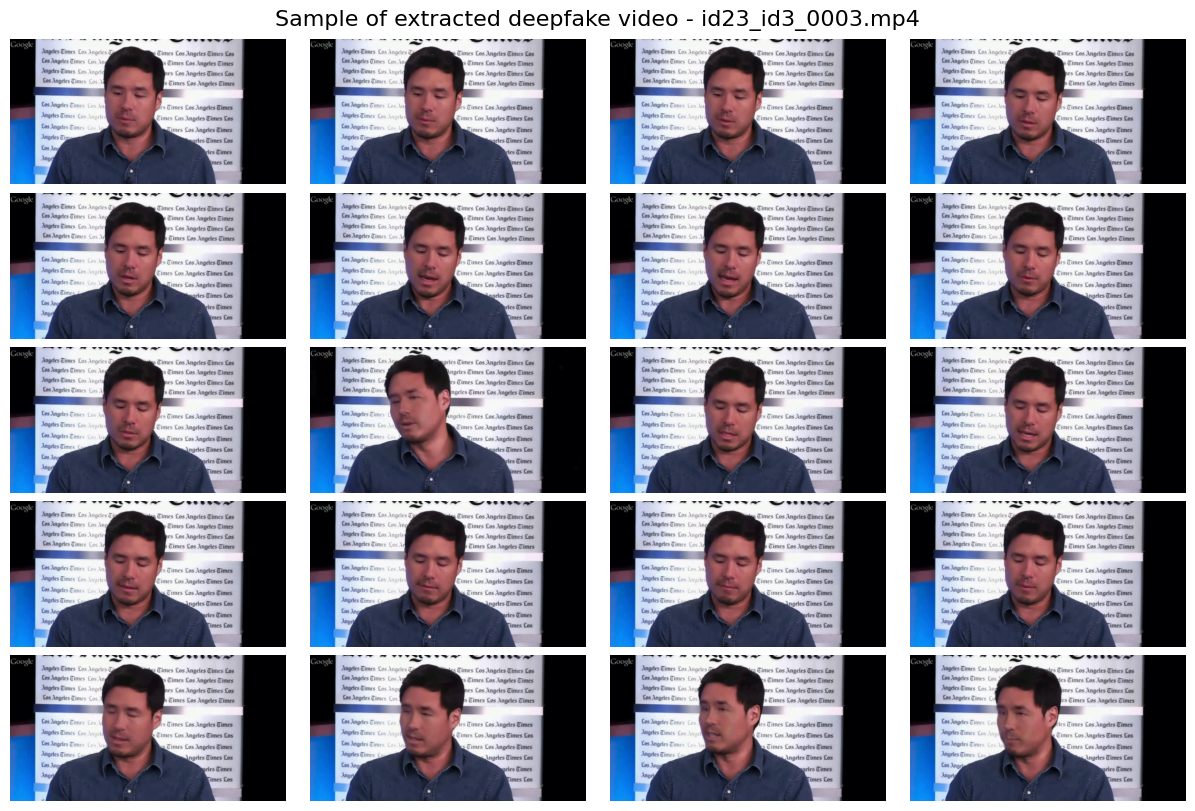

In [38]:
frame_files = [
    os.path.join(SAMPLE_FRAMES_DEEPFAKE_DIR, filename)
    for filename in os.listdir(SAMPLE_FRAMES_DEEPFAKE_DIR)[-NUM_PREVIEW_IMAGES:]
]
filename = sample_deepfakes[0].split("/")[-1]

fig, axs = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(12, 8), constrained_layout=True)
fig.suptitle(f"Sample of extracted deepfake video - {filename}", fontsize=16)

for i, ax in enumerate(axs.flatten()):
    img = plt.imread(frame_files[i])
    ax.imshow(img)
    ax.axis("off")

plt.show()